In [8]:
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
import pickle


In [2]:
train = pd.read_csv('../data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5197 non-null   float64
 1   volatile acidity      5197 non-null   float64
 2   citric acid           5197 non-null   float64
 3   residual sugar        5197 non-null   float64
 4   chlorides             5197 non-null   float64
 5   free sulfur dioxide   5197 non-null   float64
 6   total sulfur dioxide  5197 non-null   float64
 7   density               5197 non-null   float64
 8   pH                    5197 non-null   float64
 9   sulphates             5197 non-null   float64
 10  alcohol               5197 non-null   float64
 11  quality               5197 non-null   int64  
 12  type_num              5197 non-null   int64  
 13  alc-sug               5197 non-null   float64
 14  qua-sug               5197 non-null   float64
dtypes: float64(13), int64

In [3]:
X = train.drop(columns=['quality'])  
y = train['quality']  

oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

In [4]:
X=df_balanced.drop(columns=['quality'])
y=df_balanced['quality']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [6]:
from sklearn.decomposition import PCA

pipe_gs_rf_pca = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])
pipe_gs_rf_pca

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('classifier', RandomForestClassifier())])

In [9]:
params = {
    "scaler" : [StandardScaler(), None],
    "pca__n_components": [5,6,7],
    "classifier__max_depth": np.arange(3,7),
    "classifier__min_samples_leaf": [2,3,4]
}

In [10]:
pca = GridSearchCV(pipe_gs_rf_pca, params, cv=5, scoring="accuracy")

pca.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': array([3, 4, 5, 6]),
                         'classifier__min_samples_leaf': [2, 3, 4],
                         'pca__n_components': [5, 6, 7],
                         'scaler': [StandardScaler(), None]},
             scoring='accuracy')

In [11]:
print(pca.best_params_)
print(pca.best_score_)
print(pca.best_estimator_)

{'classifier__max_depth': 6, 'classifier__min_samples_leaf': 2, 'pca__n_components': 7, 'scaler': StandardScaler()}
0.6993437645579639
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=7)),
                ('classifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=2))])


In [12]:
final_pca = pca.best_estimator_.fit(X_train, y_train)
y_pred = final_pca.predict(X_test)


In [13]:
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [14]:
print("Matriz de Confusión:")
print(cm)
print("\nTasa de Aciertos (Accuracy): {:.2f}%".format(accuracy * 100))

Matriz de Confusión:
[[449   0   0   0   0   0   0]
 [  7 331  80  32  19   3   0]
 [ 22  98 248  45  35  13   3]
 [ 13  46 143  98 111  37   0]
 [  1  14  34  65 249  81  12]
 [  0   0   9  16  60 345   5]
 [  0   0   0   0   0   0 436]]

Tasa de Aciertos (Accuracy): 68.23%


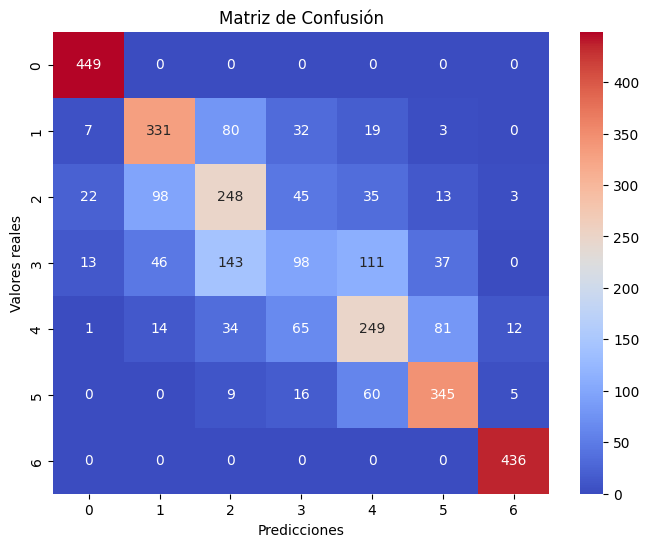

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

In [ ]:
with open('../models/trained_model_5KNN.pkl', 'wb') as archivo_salida :
    pickle.dump(final_pca, archivo_salida)